# Exercise 7 : Waveform inversion

With waveform inversion we try to find the velocity model for which the modeled data optimally fits the observed data in a least-squares sense. Mathematically, we try to solve the following optimization problem:

where  is the modeling operator and  is the observed data.

Contents:
- Camambert model
- Modeling
- Optimization
- Inversion

To illustrate some key properties of the waveform inversion problem, we are going to conduct some experiments on the famous 'Camambert' model.

# Camambert model:

The Camambert model consists of a circular perturbation,  , superimposed on a homogeneous medium,  , with velocity 2500 m/s.

In [1]:
using JUDI.TimeModeling, JUDI.SLIM_optim, PyPlot, SeisIO

In [2]:
# Velocity model

# number of gridpoints
n = (101, 101)

# Grid spacing
d = (10f0, 10f0)

# Origin
o = (0f0, 0f0)

x = zeros(n)
z = zeros(n)

for i in 0:100
    x[i+1, :] = i*10
    z[:, i+1] = i*10
end

# 
vp = 2.5f0 * ones(Float32, n)
vp[find(sqrt.((x-500).^2 +(z-500).^2) .<=225)]= 3.0f0
m = 1f0./vp.^2f0
#
v0 = 2.5f0 * ones(Float32, n)
m0 = 1f0./v0.^2f0;

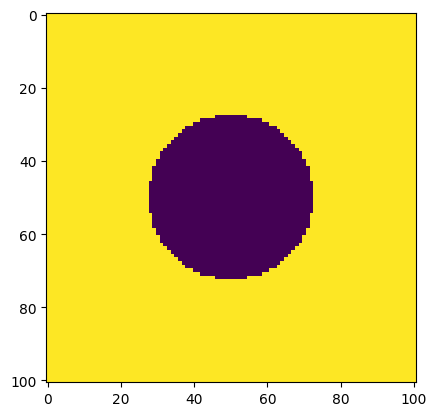

PyObject <matplotlib.image.AxesImage object at 0x1270822b0>

In [3]:
imshow(m)

In [4]:
# Set up model structure w/ squared slowness
model0 = Model(n, d, o, m0)
model = Model(n, d, o, m)

JUDI.TimeModeling.Model((101, 101), (10.0f0, 10.0f0), (0.0f0, 0.0f0), 40, Float32[0.16 0.16 … 0.16 0.16; 0.16 0.16 … 0.16 0.16; … ; 0.16 0.16 … 0.16 0.16; 0.16 0.16 … 0.16 0.16], 1)

# Source geometry

In [5]:
# Sources
nsrc = 10
xsrc = convertToCell(linspace(10f0, 990f0, nsrc))
ysrc = convertToCell(linspace(0f0, 0f0, nsrc))
zsrc = convertToCell(linspace(10f0, 10f0, nsrc))
# source sampling and number of time steps
timeS = 1000.
dtS = 2.

# Set up source structure
srcGeometry = Geometry(xsrc,ysrc,zsrc; dt=dtS, t=timeS)

JUDI.TimeModeling.GeometryIC(Any[10.0, 118.889, 227.778, 336.667, 445.556, 554.444, 663.333, 772.222, 881.111, 990.0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], Any[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0])

# Receiver geometry

In [6]:
# Receievers reflection
nrec = 50
xrec = linspace(10f0, 990f0, nrec)
yrec = 0f0
zrec = linspace(10f0, 10f0, nrec)
# source sampling and number of time steps
timeR = 1000.
dtR = 2.

# Set up receiver structure
recGeometry_reflection = Geometry(xrec,yrec,zrec;dt=dtR,t=timeR, nsrc=nsrc)

# Receievers transmission
nrec = 50
xrec = linspace(10f0, 990f0, nrec)
yrec = 0f0
zrec = linspace(990f0, 990f0, nrec)
# source sampling and number of time steps
timeR = 1000.
dtR = 2.

# Set up receiver structure
recGeometry_transmission = Geometry(xrec,yrec,zrec;dt=dtR,t=timeR, nsrc=nsrc)

JUDI.TimeModeling.GeometryIC(Any[10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0], Any[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0])

# Optimization

lbfgs (minConf_PQN here) can be used to solve optimization problems of the form:

$\min_{\mathbf{m}}\quad \phi(\mathbf{m})$

The method needs a function that calculates the misfit and gradient. The gradient of the LS misfit:

$\phi(\mathbf{m}) = \frac{1}{2}|F(\mathbf{m}) {-} \mathbf{d}|_2^2$

is given by

$\nabla\phi(\mathbf{m}) = J(\mathbf{m})^*(F(\mathbf{m}) {-} \mathbf{d})$

where $J(\mathbf{m})$ is the Jacobian matrix of $F$ and $^*# denotes the complex-conjugate-transpose (' in Julia). The Jacobian is provided by the modeling operator: `J = judiJacobian(F, q)`

Write a julia function misfit(m) that returns the value of the misfit and the gradient for the given model `m`.
minConf_SQP that function as an input


# Inversion

In the following experiments we will vary acquisition setup to emulatate a reflection and a transmission experiment:

Reflection setup: `reflection_data.segy`.
Transmission setup:`transmission_data.segy`.

- define the function-handle as described above.
- define an initial model m0 by converting v0 to the proper units.
- use lbfgs| for a small amount of iterations (10, say).

Compare the results of both experiments in terms of:

- reconstruction
- data-fit


In order to obtain nice conergence use the following bound constraint

# Bound projection
ProjBound(x) = boundproject(x, maximum(m), .9*minimum(m))

# Setup

In [7]:
# To setup the operator in for example the reflection case

# setup wavelet
f0 = 0.01  # 5 Hz wavelet
wavelet = ricker_wavelet(timeS, dtS, f0)
q = judiVector(srcGeometry, wavelet)


# Set up info structure for linear operators
ntComp = get_computational_nt(srcGeometry, recGeometry_reflection, model)
ntComp0 = get_computational_nt(srcGeometry, recGeometry_reflection, model0)
info = Info(prod(n), nsrc, ntComp)
info0 = Info(prod(n), nsrc, ntComp0)

JUDI.TimeModeling.Info(10201, 10, Any[596, 596, 596, 596, 596, 596, 596, 596, 596, 596])

In [8]:

F_r = judiModeling(info, model, srcGeometry, recGeometry_reflection)

F_t = judiModeling(info, model, srcGeometry, recGeometry_transmission)

JUDI.TimeModeling.judiPDEfull{Float32,Float32}("Proj*F*Proj'", 250500, 5010, JUDI.TimeModeling.Info(10201, 10, Any[715, 715, 715, 715, 715, 715, 715, 715, 715, 715]), JUDI.TimeModeling.Model((101, 101), (10.0f0, 10.0f0), (0.0f0, 0.0f0), 40, Float32[0.16 0.16 … 0.16 0.16; 0.16 0.16 … 0.16 0.16; … ; 0.16 0.16 … 0.16 0.16; 0.16 0.16 … 0.16 0.16], 1), JUDI.TimeModeling.GeometryIC(Any[10.0, 118.889, 227.778, 336.667, 445.556, 554.444, 663.333, 772.222, 881.111, 990.0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], Any[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]), JUDI.TimeModeling.GeometryIC(Any[10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0

In [9]:
d_trans = F_t * q

JUDI.TimeModeling.judiVector{Float32}("Seismic data vector", 250500, 1, 10, JUDI.TimeModeling.GeometryIC(Any[10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0, 10.0f0:20.0f0:990.0f0], Any[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Any[990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0, 990.0f0:0.0f0:990.0f0], Any[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], Any[501, 501, 501, 501, 501, 501, 501, 501, 501, 501], Any[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]), Array[Float32[0.0 0.0 … -0.0 0.0; -0.0 -0.0 … 0.0 -0.0; … ; 0.117519 0.108306 … -0.0149311 -0.02242; 0.0 0.0 … 0.0 0.0], Float32[-0.0 -0.0 … -0.0 0.0; 0.0 0.0 … 0.0 -0.0; … ;

In [10]:
function f(x)
    
    # Update model
    model0.m = convert(Array{Float32, 2}, reshape(x, model0.n))
    F0_t = judiModeling(info0, model0, srcGeometry, recGeometry_transmission)
    J = judiJacobian(F0_t, q)
    
    # Synthetic data
    d_syn = F0_t*q
    
    # residual
    
    residual = d_syn - d_trans
    
    # Misfit
    
    f = .5*norm(residual)^2
    
    # gradient
    
    grad = J'*residual
    
    return f, vec(grad)
end
    

f (generic function with 1 method)

In [11]:
F0_t = judiModeling(info0, model0, srcGeometry, recGeometry_transmission)
J = judiJacobian(F_t, q);

dm = J'*d_trans

LoadError: [91m[91m[91mPyError (ccall(@pysym(:PyFloat_AsDouble), Cdouble, (PyPtr,), po)) <class 'TypeError'>
TypeError('only size-1 arrays can be converted to Python scalars',)
[39m
pyerr_check at /Users/mathiaslouboutin/.julia/v0.6/PyCall/src/exception.jl:60 [inlined]
convert(::Type{Float32}, ::PyCall.PyObject) at /Users/mathiaslouboutin/.julia/v0.6/PyCall/src/conversions.jl:58
py2array(::Type{T} where T, ::Array{Float32,1}, ::PyCall.PyObject, ::Int64, ::Int64) at /Users/mathiaslouboutin/.julia/v0.6/PyCall/src/conversions.jl:343
py2array(::Type{T} where T, ::PyCall.PyObject) at /Users/mathiaslouboutin/.julia/v0.6/PyCall/src/conversions.jl:394
convert(::Type{Array{Float32,2}}, ::PyCall.PyObject) at /Users/mathiaslouboutin/.julia/v0.6/PyCall/src/pyarray.jl:277
#pycall#97(::Array{Any,1}, ::Function, ::PyCall.PyObject, ::Type{Array{Float32,2}}, ::PyCall.PyObject, ::Vararg{PyCall.PyObject,N} where N) at /Users/mathiaslouboutin/.julia/v0.6/PyCall/src/pyfncall.jl:83
(::PyCall.#kw##pycall)(::Array{Any,1}, ::PyCall.#pycall, ::PyCall.PyObject, ::Type{Array{Float32,2}}, ::PyCall.PyObject, ::Vararg{PyCall.PyObject,N} where N) at ./<missing>:0
devito_interface(::PyCall.PyObject, ::Tuple{Float32,Float32}, ::JUDI.TimeModeling.GeometryIC, ::Array{Any,1}, ::JUDI.TimeModeling.GeometryIC, ::Array{Any,1}, ::Void, ::JUDI.TimeModeling.Options) at /Users/mathiaslouboutin/.julia/v0.6/JUDI/src/TimeModeling/time_modeling_serial.jl:289
time_modeling(::JUDI.TimeModeling.Model, ::JUDI.TimeModeling.GeometryIC, ::Array{Any,1}, ::JUDI.TimeModeling.GeometryIC, ::Array{Any,1}, ::Void, ::Int64, ::Char, ::Int64, ::JUDI.TimeModeling.Options) at /Users/mathiaslouboutin/.julia/v0.6/JUDI/src/TimeModeling/time_modeling_serial.jl:50
(::Base.Distributed.##135#136{JUDI.TimeModeling.#time_modeling,Tuple{JUDI.TimeModeling.Model,JUDI.TimeModeling.GeometryIC,Array{Any,1},JUDI.TimeModeling.GeometryIC,Array{Any,1},Void,Int64,Char,Int64,JUDI.TimeModeling.Options},Array{Any,1}})() at ./distributed/remotecall.jl:314
run_work_thunk(::Base.Distributed.##135#136{JUDI.TimeModeling.#time_modeling,Tuple{JUDI.TimeModeling.Model,JUDI.TimeModeling.GeometryIC,Array{Any,1},JUDI.TimeModeling.GeometryIC,Array{Any,1},Void,Int64,Char,Int64,JUDI.TimeModeling.Options},Array{Any,1}}, ::Bool) at ./distributed/process_messages.jl:56
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:339
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:339
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:367
remotecall_fetch(::Function, ::Int64, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:367
#remotecall_pool#163(::Array{Any,1}, ::Function, ::Function, ::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:112
remotecall_pool(::Function, ::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:110
#remotecall_fetch#180(::Array{Any,1}, ::Function, ::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:178
remotecall_fetch(::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:178
(::Base.Distributed.###184#185#187{JUDI.TimeModeling.#time_modeling})(::Array{Any,1}, ::Function, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:214
(::Base.Distributed.##184#186)(::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:214
(::Base.###49#50#52{ExponentialBackOff,Void,Base.Distributed.##184#186})(::Array{Any,1}, ::Function, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./error.jl:139
(::JUDI.TimeModeling.##61#65{JUDI.TimeModeling.Model,Char,Int64,Base.##49#51,Array{Any,1}})() at ./task.jl:335[39m
#remotecall_fetch#140(::Array{Any,1}, ::Function, ::Function, ::Base.Distributed.LocalProcess, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:340
remotecall_fetch(::Function, ::Base.Distributed.LocalProcess, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:339
#remotecall_fetch#144(::Array{Any,1}, ::Function, ::Function, ::Int64, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:367
remotecall_fetch(::Function, ::Int64, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/remotecall.jl:367
#remotecall_pool#163(::Array{Any,1}, ::Function, ::Function, ::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:112
remotecall_pool(::Function, ::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:110
#remotecall_fetch#180(::Array{Any,1}, ::Function, ::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:178
remotecall_fetch(::Function, ::WorkerPool, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:178
(::Base.Distributed.###184#185#187{JUDI.TimeModeling.#time_modeling})(::Array{Any,1}, ::Function, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:214
(::Base.Distributed.##184#186)(::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./distributed/workerpool.jl:214
(::Base.###49#50#52{ExponentialBackOff,Void,Base.Distributed.##184#186})(::Array{Any,1}, ::Function, ::JUDI.TimeModeling.Model, ::Vararg{Any,N} where N) at ./error.jl:139
(::JUDI.TimeModeling.##61#65{JUDI.TimeModeling.Model,Char,Int64,Base.##49#51,Array{Any,1}})() at ./task.jl:335

...and 9 more exception(s).
[39m

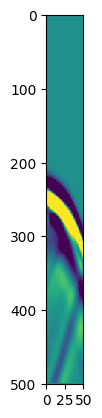

PyObject <matplotlib.image.AxesImage object at 0x14927cda0>

In [12]:
imshow(d_trans.data[1], vmin=-1, vmax=1)

In [13]:
# invert
options = pqn_options(verbose=3, maxIter=10, corrections=10)
# Bound projection
ProjBound(x) = boundproject(x, maximum(m), .9*minimum(m))
# x, fsave, funEvals= minConf_PQN(f, vec(m0), ProjBound, options)

ProjBound (generic function with 1 method)